In [96]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import random
import torchvision.transforms as transforms
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
#from google.colab import drive

from torchvision import datasets, transforms


import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [97]:
#input_size = 198*120
#input_size = 11760
#input_size = 7680

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet,self).__init__()
        self.l1 = nn.Linear(input_size,160) # first layer
        self.relu = nn.ReLU() # activation function
        self.l2 = nn.Linear(160,num_classes) # second layer

    def forward(self,x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

In [98]:
# Training function.
def train(epoch, model, loader, criterion, optimizer, device='cpu'):
    l = 0
    for data in tqdm(loader, desc=f'Epoch {epoch+1:03d}'):
        x = data[0].to(device)
        #x = x.view(x.size(0), -1)
        #x = x.view(-1, 198*120)  # flattena le immagini
        y = data[1].squeeze().to(device)
        #print(x.shape)
        out = model(x)
        loss = criterion(out, y) 
        l += loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return l

# Test function.
def test(model, loader, criterion, device='cpu'):
    l = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in loader:
            x = data[0].to(device)
            #x = x.view(-1, 198*120)  # flattena le immagini
            y = data[1].squeeze().to(device)
            out = model(x)
            l += criterion(out, y)
            _, pred = torch.max(out.data, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            y_true += y.tolist()
            y_pred += pred.tolist()
    return l, correct / total, y_true, y_pred

In [99]:
# Mounta il drive di Google
#drive.mount('/content/drive')

# Definisci le cartelle delle immagini
train_dir = 'Images/train'
test_dir = 'Images/test'

# Definisci le etichette
etichette = ['N', 'A', 'V']

# Crea un dizionario per mappare le etichette ai valori numerici
etichette_map = {etichetta: i for i, etichetta in enumerate(etichette)}

# Funzione per caricare le immagini e le loro etichette
class ImmaginiDataset(torch.utils.data.Dataset):
    def __init__(self, dir, transform=None):
        self.dir = dir
        self.transform = transform
        self.images = []
        for etichetta in etichette:
            path = os.path.join(dir, etichetta)
            for file in os.listdir(path):
                self.images.append((os.path.join(path, file), etichetta))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        path, etichetta = self.images[index]
        #immagine = torchvision.io.read_image(path, mode=torchvision.io.ImageReadMode.LZW)
        immagine = Image.open(path).convert('L') # Converti in bianco e nero
        if self.transform:
            immagine = self.transform(immagine)
        return immagine, etichette_map[etichetta]

# Crea il dataset per l'addestramento
train_dataset = ImmaginiDataset(train_dir)

# Applica le trasformazioni alle immagini
train_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

train_dataset.transform = train_transformations

# Crea il dataset per il test
test_dataset = ImmaginiDataset(test_dir)
test_dataset.transform = train_transformations

# Crea i dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Device configuration.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyper-parameters.
num_classes = len(etichette)
num_epochs = 5
learning_rate = 0.001


cpu


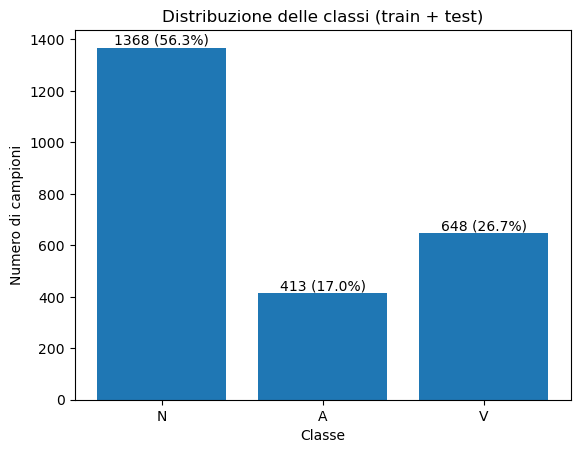

In [116]:
def stampa_istogramma(train_loader, test_loader, etichette):
    classi = [0] * len(etichette)
    with torch.no_grad():
        for loader in [train_loader, test_loader]:
            for _, labels in loader:
                for label in labels:
                    classi[label.item()] += 1
    totale = sum(classi)
    plt.bar(etichette, classi)
    for i, valore in enumerate(classi):
        plt.text(i, valore, f"{valore} ({valore / totale * 100:.1f}%)", ha='center', va='bottom')
    plt.xlabel('Classe')
    plt.ylabel('Numero di campioni')
    plt.title('Distribuzione delle classi (train + test)')
    plt.show()

# Stampa istogramma per i dataset di addestramento e test combinati
stampa_istogramma(train_loader, test_loader, etichette)


In [100]:
# creo architettura CNN
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        #Qui devo metterci:
        self.fc = NeuralNet(20 * 11 * 16, num_classes) 
        #se voglio avere modelli confrontabili 
        #self.fc = nn.Linear(20 * 11 * 16, num_classes)

    def forward(self, x):
        #print(f"Input: {x.shape}")
        out = self.layer1(x)
        #print(f"Dopo layer 1: {out.shape}")
        out = self.layer2(out)
        #print(f"Dopo layer 2: {out.shape}")
        out = out.reshape(out.size(0), -1)
        #print(f"Output appiattito: {out.shape}")
        out = self.fc(out)
        #print(f"Output FC: {out.shape}")
        return out


# Create the model.
model = ConvNet(num_classes).to(device)

In [101]:
# TRAIN E TEST CNN

# Loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and test._get_conv_output_size
for epoch in range(num_epochs):
    train_loss = train(epoch, model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, y_true, y_pred = test(model, test_loader, criterion, device)
    print(f'Epoch {epoch+1:03d}: training loss {train_loss:.4f}, test loss {test_loss:.4f}, test acc {test_acc:.4f}')

print(classification_report(y_true, y_pred, zero_division=0))


Epoch 001: 100%|██████████| 31/31 [00:09<00:00,  3.25it/s]


Epoch 001: training loss 30.6204, test loss 8.0756, test acc 0.5726


Epoch 002: 100%|██████████| 31/31 [00:09<00:00,  3.40it/s]


Epoch 002: training loss 30.7435, test loss 7.7841, test acc 0.5726


Epoch 003: 100%|██████████| 31/31 [00:08<00:00,  3.47it/s]


Epoch 003: training loss 27.7661, test loss 6.8720, test acc 0.7674


Epoch 004: 100%|██████████| 31/31 [00:09<00:00,  3.28it/s]


Epoch 004: training loss 17.6583, test loss 4.3886, test acc 0.7853


Epoch 005: 100%|██████████| 31/31 [00:09<00:00,  3.40it/s]


Epoch 005: training loss 11.2331, test loss 3.7469, test acc 0.8469
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       288
           1       0.71      0.67      0.69        83
           2       0.99      0.73      0.84       132

    accuracy                           0.85       503
   macro avg       0.85      0.79      0.81       503
weighted avg       0.86      0.85      0.84       503



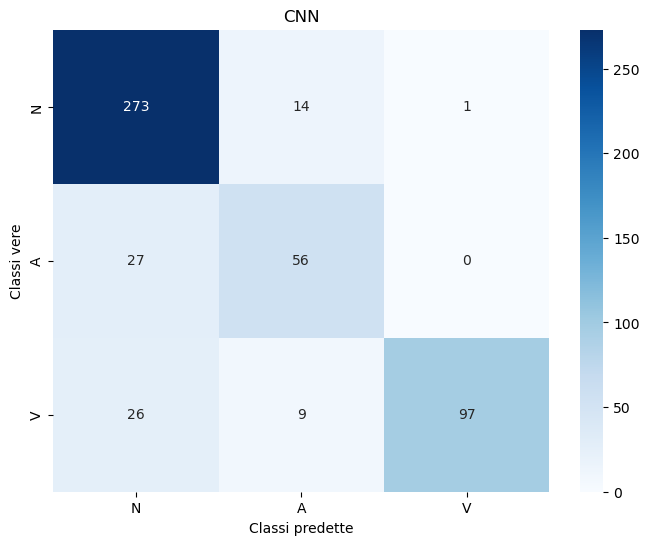

In [102]:
# Creazione della matrice di confusione
cm = confusion_matrix(y_true, y_pred)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
            xticklabels=etichette, yticklabels=etichette)
plt.xlabel('Classi predette')
plt.ylabel('Classi vere')
plt.title('CNN')

plt.show()


In [103]:
# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = nn.functional.interpolate(x, size=(120, 198)) #interpolazione per raggiungere le dimensioni di output
        return x


# Initialize the autoencoder
model = Autoencoder().to(device)

In [104]:
# addestro autoencoder

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the autoencoder
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        #print(img.shape)
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    #if epoch % 5== 0:
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Save the model
torch.save(model.state_dict(), 'conv_autoencoder.pth')

Epoch [1/5], Loss: 0.2390
Epoch [2/5], Loss: 0.0510
Epoch [3/5], Loss: 0.0282
Epoch [4/5], Loss: 0.0235
Epoch [5/5], Loss: 0.0190


<Figure size 1600x1200 with 0 Axes>

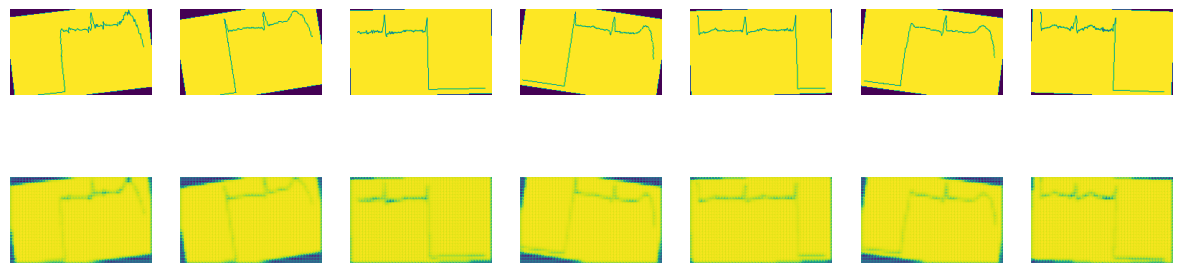

In [105]:
# Genero immagini per fare un esempio

with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon = model(data)
        break
        
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

In [106]:
# Estraggo le feature


# Assumiamo che 'etichette' e 'etichette_map' siano già definiti come in [1]
# Assumiamo che 'ImmaginiDataset', 'train_transformations', 'train_loader', 'test_loader' siano già definiti come in [2-4]

# Inizializza l'autoencoder e carica il suo stato addestrato [7, 8]
autoencoder_model = Autoencoder().to(device)
autoencoder_model.load_state_dict(torch.load('conv_autoencoder.pth'))
autoencoder_model.eval() # Imposta il modello in modalità valutazione (disabilita dropout/batchnorm se presenti)

# Liste per salvare le feature e le etichette estratte per il training set
latent_features_train = []
labels_train = []

# Estrazione delle feature dal training set
with torch.no_grad(): # Non calcolare i gradienti per risparmiare memoria e tempo
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        # Estrai le feature utilizzando solo l'encoder dell'Autoencoder
        features = autoencoder_model.encoder(images)
        # Appiattisci le feature per renderle un vettore 1D per ogni immagine
        # La dimensione finale delle feature appiattite dovrebbe essere 8 * 49 * 30 = 11760
        features = features.reshape(features.size(0), -1)
        latent_features_train.append(features.cpu()) # Sposta sulla CPU per concatenazione successiva
        labels_train.append(labels.cpu())

# Concatena tutte le feature e le etichette del training set in un unico tensore
all_latent_features_train = torch.cat(latent_features_train, dim=0)
all_labels_train = torch.cat(labels_train, dim=0)
print(f"Dimensioni totali delle feature latenti (training): {all_latent_features_train.shape}")
print(f"Dimensioni totali delle etichette (training): {all_labels_train.shape}")

# Liste per salvare le feature e le etichette estratte per il test set
latent_features_test = []
labels_test = []

# Estrazione delle feature dal test set
with torch.no_grad(): # Non calcolare i gradienti per risparmiare memoria e tempo
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        # Estrai le feature utilizzando solo l'encoder dell'Autoencoder [6]
        features = autoencoder_model.encoder(images)
        # Appiattisci le feature [9]
        features = features.reshape(features.size(0), -1)
        latent_features_test.append(features.cpu())
        labels_test.append(labels.cpu())

# Concatena tutte le feature e le etichette del test set in un unico tensore
all_latent_features_test = torch.cat(latent_features_test, dim=0)
all_labels_test = torch.cat(labels_test, dim=0)
print(f"Dimensioni totali delle feature latenti (test): {all_latent_features_test.shape}")
print(f"Dimensioni totali delle etichette (test): {all_labels_test.shape}")

# Opzionale: Puoi salvare queste feature e etichette su disco se necessario, ad esempio con torch.save()
# torch.save({'features': all_latent_features_train, 'labels': all_labels_train}, 'latent_features_train.pt')
# torch.save({'features': all_latent_features_test, 'labels': all_labels_test}, 'latent_features_test.pt')

/tmp/ipykernel_7766/138960899.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder_model.load_state_dict(torch.load('conv_autoencoder.pth'))


Dimensioni totali delle feature latenti (training): torch.Size([1926, 11760])
Dimensioni totali delle etichette (training): torch.Size([1926])
Dimensioni totali delle feature latenti (test): torch.Size([503, 11760])
Dimensioni totali delle etichette (test): torch.Size([503])


In [107]:
# # TRAINING E TEST SOLO RETE DENSA CON SPAZIO LATENTE backup funzionante

# #input_size = 198*120
# input_size = 11760
# #input_size = 7680


# model = NeuralNet(input_size,num_classes).to(device)


# # Loss and optimizer.
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# # Training 
# for epoch in range(num_epochs):
#     model.train()
#     optimizer.zero_grad()
#     outputs = model(all_latent_features_train)
#     loss = criterion(outputs, all_labels_train)
#     loss.backward()
#     optimizer.step()
#     print(f'Epoch {epoch+1:03d}, Loss: {loss.item():.4f}')

# # test
# model.eval()
# with torch.no_grad():
#     outputs = model(all_latent_features_test)
#     _, predicted = torch.max(outputs, 1)
#     y_pred = predicted.cpu().numpy()
#     y_true = all_labels_test.cpu().numpy()
#     print(classification_report(y_true, y_pred, zero_division=0))

In [108]:
# TRAINING E TEST SOLO RETE DENSA CON SPAZIO LATENTE

#input_size = 198*120
input_size = 11760
#input_size = 7680

model = NeuralNet(input_size,num_classes).to(device)

# Loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training 
train_loader_dense = torch.utils.data.DataLoader(
    list(zip(all_latent_features_train, all_labels_train)),
    batch_size=64,
    shuffle=True
)

for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, labels) in enumerate(train_loader_dense):
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1:03d}, Loss: {loss.item():.4f}')

# test
model.eval()
with torch.no_grad():
    outputs = model(all_latent_features_test)
    _, predicted = torch.max(outputs, 1)
    y_pred = predicted.cpu().numpy()
    y_true = all_labels_test.cpu().numpy()
    print(classification_report(y_true, y_pred, zero_division=0))


Epoch 001, Loss: 1.9893
Epoch 002, Loss: 0.7041
Epoch 003, Loss: 2.4391
Epoch 004, Loss: 0.8976
Epoch 005, Loss: 0.4527
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       288
           1       0.00      0.00      0.00        83
           2       0.00      0.00      0.00       132

    accuracy                           0.57       503
   macro avg       0.19      0.33      0.24       503
weighted avg       0.33      0.57      0.42       503



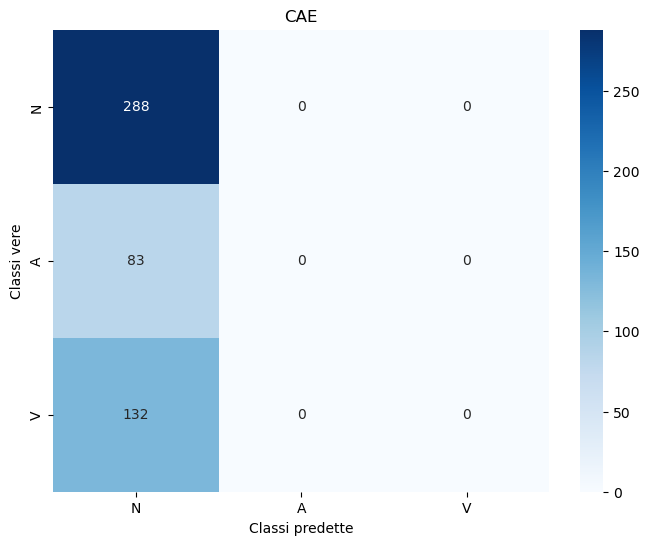

In [109]:
# Creazione della matrice di confusione
cm = confusion_matrix(y_true, y_pred)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
            xticklabels=etichette, yticklabels=etichette)
plt.xlabel('Classi predette')
plt.ylabel('Classi vere')
plt.title('CAE')

plt.show()

In [110]:
# Inizializza l'autoencoder e carica il suo stato addestrato
autoencoder_model = Autoencoder().to(device) # 'Autoencoder' definito in
autoencoder_model.load_state_dict(torch.load('conv_autoencoder.pth'))
autoencoder_model.eval()

# Training function per la CNN (ConvNet)
def trainAE(epoch, model, loader, criterion, optimizer, device='cpu', autoencoder_model=None): # autoencoder_model è un nuovo parametro
    l = 0
    model.train() # Imposta la CNN in modalità addestramento
    for data in tqdm(loader, desc=f'Epoch {epoch+1:03d}'):
        # data sono le immagini originali, data sono le etichette
        original_img = data[0].to(device)
        y = data[1].squeeze().to(device)
        
        # Usa l'autoencoder per ricostruire l'immagine
        with torch.no_grad():
            x = autoencoder_model(original_img) # Ottieni l'immagine ricostruita
        
        # Passa l'immagine ricostruita alla CNN
        out = model(x) # 'model' qui è la tua istanza di ConvNet
        
        loss = criterion(out, y)
        l += loss.item() # Usa .item() per sommare i valori scalari di loss
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
            
    return l / len(loader) # Ritorna la loss media

# Test function per la CNN (ConvNet)
def testAE(model, loader, criterion, device='cpu', autoencoder_model=None): # autoencoder_model è un nuovo parametro
    l = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    model.eval() # Imposta la CNN in modalità valutazione

    with torch.no_grad(): # Nessun calcolo dei gradienti per il test
        for data in loader:
            # data sono le immagini originali, data sono le etichette
            #original_img = data[0].to(device)
            y = data[1].squeeze().to(device)

            
            # Se volessi usare l'autoencoder per ricostruire l'immagine
            #x = autoencoder_model(original_img) # Ottieni l'immagine ricostruita
            # Uso le immagini originali per il test
            x = data[0].to(device)
            out = model(x)
            
            l += criterion(out, y).item() # Usa .item() per sommare i valori scalari di loss
            _, pred = torch.max(out.data, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            y_true += y.tolist()
            y_pred += pred.tolist()
            
    return l / len(loader), correct / total, y_true, y_pred # Ritorna loss media, accuratezza, liste di veri e predetti

# Crea l'istanza della CNN (ConvNet)
model = ConvNet(num_classes).to(device)

# Funzione di Loss e Ottimizzatore per la CNN
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Ciclo di addestramento e test per la CNN
for epoch in range(num_epochs):
    # Passa l'autoencoder_model alla funzione train
    train_loss = trainAE(epoch, model, train_loader, criterion, optimizer, device, autoencoder_model=autoencoder_model)
    #train_loss = train(epoch, model, train_loader, criterion, optimizer, device)

    # Passa l'autoencoder_model alla funzione test
    test_loss, test_acc, y_true, y_pred = testAE(model, test_loader, criterion, device, autoencoder_model=autoencoder_model)
    #test_loss, test_acc, y_true, y_pred = test(model, test_loader, criterion, device)

    print(f'Epoch {epoch+1:03d}: training loss {train_loss:.4f}, test loss {test_loss:.4f}, test acc {test_acc:.4f}')

print(classification_report(y_true, y_pred, zero_division=0))


/tmp/ipykernel_7766/2639461547.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder_model.load_state_dict(torch.load('conv_autoencoder.pth'))
Epoch 001: 100%|████

Epoch 001: training loss 1.0026, test loss 0.9738, test acc 0.5726


Epoch 002: 100%|██████████| 31/31 [00:14<00:00,  2.14it/s]


Epoch 002: training loss 0.9774, test loss 0.9848, test acc 0.5726


Epoch 003: 100%|██████████| 31/31 [00:14<00:00,  2.20it/s]


Epoch 003: training loss 0.9929, test loss 1.0011, test acc 0.5726


Epoch 004: 100%|██████████| 31/31 [00:14<00:00,  2.13it/s]


Epoch 004: training loss 0.9915, test loss 0.9746, test acc 0.5726


Epoch 005: 100%|██████████| 31/31 [00:14<00:00,  2.19it/s]


Epoch 005: training loss 0.9851, test loss 0.9794, test acc 0.5726
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       288
           1       0.00      0.00      0.00        83
           2       0.00      0.00      0.00       132

    accuracy                           0.57       503
   macro avg       0.19      0.33      0.24       503
weighted avg       0.33      0.57      0.42       503



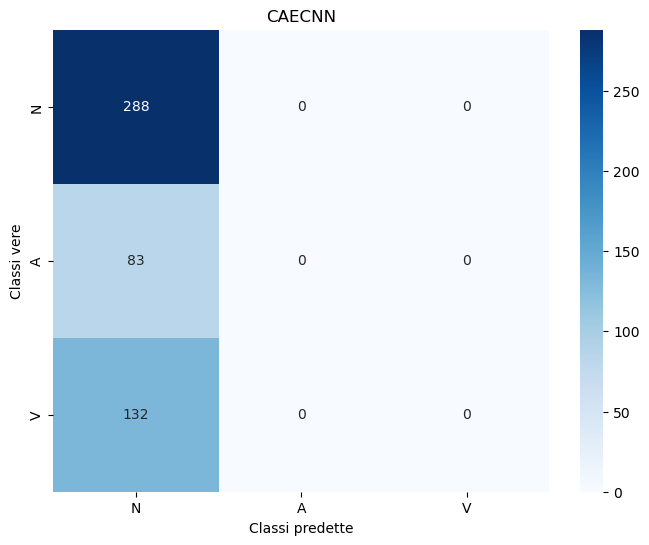

In [111]:
# Creazione della matrice di confusione
cm = confusion_matrix(y_true, y_pred)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
            xticklabels=etichette, yticklabels=etichette)
plt.xlabel('Classi predette')
plt.ylabel('Classi vere')
plt.title('CAECNN')

plt.show()